In [1]:
#!/usr/bin/env python
# coding: utf-8
import os
from time import gmtime, strftime

import numpy as np
import torch
import torch.nn as nn

# ---- My utils ----
from models import *
from utils.utils_data import *
from utils.utils_training import *
from utils.data_augmentation import get_augmentations

from shutil import copyfile
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, accuracy_score

In [2]:
class Arguments(object):

    def __init__(self):
        
        self.verbose = False
        self.optimizer = "adam"
        self.epochs = 120
        self.batch_size = 256
        self.learning_rate = 0.0001
        self.min_learning_rate = 1e-07
        self.get_path = False
        self.weighted_loss = False
        self.plateau_scheduler = False
        self.steps_best = False
        self.steps_scheduler = True
        self.binary_problem = False
        self.multilabel_problem = True
        self.damaged_problem = False
        self.segmentation_problem = False
        self.masks_overlays = 0
        self.selected_class = None
        self.img_size = 256
        self.crop_size = 224
        self.model_name = "resnet34"
        self.checkpoint = None
        self.data_mod = None
        self.pretrained = True
        self.fold = 0
        self.output_dir = "results/MultiLabelClassification/fold0/resnet34_adam_256to224_lr0.0001_DA_pretrained/"
        self.data_augmentation = True
        self.histogram_matching = False
        
args = Arguments()

#### Load data

In [3]:
train_aug, val_aug, train_albumentation, val_albumentation = get_augmentations(
    args.data_augmentation, args.pretrained, args.img_size, args.crop_size, args.segmentation_problem
)

In [4]:
train_dataset, train_loader, val_dataset, val_loader, num_classes = dataset_selector(
    train_aug, train_albumentation, val_aug, val_albumentation, args
)

print("There are {} classes!".format(num_classes))
print("[Train fold] {} samples".format(len(train_dataset)))
print("[Validation fold] {} samples".format(len(val_dataset)))

There are 8 classes!
[Train fold] 7640 samples
[Validation fold] 1910 samples


#### Load model

In [5]:
model = model_selector(args.model_name, num_classes=num_classes, pretrained=args.pretrained)
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))

model.load_state_dict(torch.load(os.path.join(args.output_dir, "model_best_metric.pt")))
model.eval()
print("Model loaded correctly!")

Pretrained-> Remember at end: transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Model loaded correctly!


#### Check metrics

In [7]:
criterion = nn.BCEWithLogitsLoss()
epoch = 0

current_val_loss, current_val_metric, val_precision_score, val_recall_score, val_f1_score, val_dice = val_step(
    val_loader, model, criterion, args.segmentation_problem,
    selected_class=args.selected_class, masks_overlays=args.masks_overlays, epoch=(epoch+1), lr=args.learning_rate
)

In [8]:
current_time = "[" + strftime("%Y-%m-%d %H:%M:%S", gmtime()) + "]"
str_epoch = epoch + 1
str_logline = "Val Recall: {:.4f}, Val Precision: {:.4f}, Val F1: {:.4f}".format(
    val_recall_score, val_precision_score, val_recall_score, val_f1_score
)
str_logline

'Val Recall: 0.9295, Val Precision: 0.9295, Val F1: 0.9295'

### Perform inference

In [10]:
val_loader.dataset.get_path = True

all_outs, all_targets, all_paths = [], [], []
with torch.no_grad():
    for batch_idx, (inputs, targets, img_path) in enumerate(val_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        
        all_outs.append(outputs)
        all_targets.append(targets)
        all_paths.extend(img_path)

all_outs_logits = torch.cat(all_outs)
all_targets = torch.cat(all_targets).squeeze()

## Preds to files

In [12]:
save_dir = "classification_preds"
os.makedirs(save_dir, exist_ok=True)

In [11]:
threshold = 0.5
all_outs_thresholded = (nn.Sigmoid()(all_outs_logits) > threshold).float()

In [13]:
max_index = all_outs_thresholded.sum(dim=1).argmax().item()
max_num_calsses_image = int(all_outs_thresholded.sum(dim=1).max())
print(f"Max number classes in image: {max_num_calsses_image} at index {max_index}")

Max number classes in image: 5 at index 1848


In [37]:
CLASSES = [
    "Alcantarillado", "Marca vial", "Hueco", "Parcheo", "Grietas longitudinales",
    "Grietas en forma de piel de cocodrilo", "Grietas transversales",
    "Meteorización y desprendimiento", #"Espiras Magnéticas"
]

In [38]:
avg = 'micro'
for indx, clase in enumerate(CLASSES):
    pr = precision_score( all_targets[:,indx].cpu(), all_outs_thresholded[:,indx].cpu(), average=avg )
    pr = precision_score( all_targets[:,indx].cpu(), all_outs_thresholded[:,indx].cpu(), average=avg )
    print(f"[{clase}] Precision: {pr}")

[Alcantarillado] Precision: 0.9968586387434555
[Marca vial] Precision: 0.987958115183246
[Hueco] Precision: 0.9832460732984293
[Parcheo] Precision: 0.9863874345549738
[Grietas longitudinales] Precision: 0.9638743455497382
[Grietas en forma de piel de cocodrilo] Precision: 0.9958115183246073
[Grietas transversales] Precision: 0.9706806282722513
[Meteorización y desprendimiento] Precision: 0.9884816753926702


In [21]:
for indx, (target, out, path) in enumerate(zip(all_targets, all_outs_thresholded, all_paths)):
    
    is_correct = "correct" if ((target*out).sum() == target.sum()).item() else "incorrect"
    
    str_classes_out = " - ".join([pareja[0] for pareja in zip(val_dataset.classes, out.tolist()) if pareja[1]])
    str_classes_target = " - ".join([pareja[0] for pareja in zip(val_dataset.classes, target.tolist()) if pareja[1]])
    
    str_classes_out = str_classes_out if str_classes_out != "" else "NoDistress"
    str_classes_target = str_classes_target if str_classes_target != "" else "NoDistress"
    
    _, _, version, _, filename = path.split("/")
    
    
    num_classes = int(out.sum().item())
    new_parent_dir = os.path.join(save_dir, "by_pred", f"{str(num_classes)}_classes", is_correct)
    os.makedirs(new_parent_dir, exist_ok=True)
    new_path = os.path.join(new_parent_dir, f"TARGET__{str_classes_target}__PREDICTED__{str_classes_out}__{filename}")
    copyfile(path, new_path)
    
    num_classes = int(target.sum().item())
    new_parent_dir = os.path.join(save_dir, "by_target", f"{str(num_classes)}_classes", is_correct)
    os.makedirs(new_parent_dir, exist_ok=True)
    new_path = os.path.join(new_parent_dir, f"TARGET__{str_classes_target}__PREDICTED__{str_classes_out}__{filename}")
    copyfile(path, new_path)

## Threshold Analysis

In [22]:
import ipywidgets as widgets
from ipywidgets import interact, interactive
from sklearn.metrics import precision_score, recall_score, f1_score

In [23]:
@interact(threshold=(0,1,0.05))

def conf_matrix(threshold=0.5):
    matrix = np.zeros((2,2))

    all_outs_thresholded = (nn.Sigmoid()(all_outs_logits) > threshold).float()

    for indx, (target, out, path) in enumerate(zip(all_targets, all_outs_thresholded, all_paths)):
        itarget = int(target.sum().item())
        iout = int(out.sum().item())

        itarget = 1 if itarget >= 1 else 0
        iout = 1 if iout >= 1 else 0

        matrix[itarget, iout]+=1

    plt.figure(figsize=(7, 6)) # width and height in inches
    sns.heatmap(matrix, annot=True, cmap='YlGnBu', fmt='g', xticklabels=["Nothing", "Something"], yticklabels=["Nothing", "Something"])
    plt.tick_params(axis='both', which='major', labelsize=11, labelbottom = False, bottom=False, top = False, labeltop=True)
    plt.yticks(rotation=0) 
    
    val_recall_score = recall_score(all_targets.cpu(), all_outs_thresholded.cpu(), average="micro")
    print(f"Validation Recall: {val_recall_score:{1}.{4}}")

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

# ALL FOLDS

In [24]:
CLASSES = [
    "Alcantarillado", "Marca vial", "Hueco", "Parcheo", "Grietas longitudinales",
    "Grietas en forma de piel de cocodrilo", "Grietas transversales",
    "Meteorización y desprendimiento", #"Espiras Magnéticas"
]

metrics_str = ["precision", "recall", "f1"]
res_metrics = {}
for clase in CLASSES:
    for metric_str in metrics_str:
        res_metrics[f"{clase}_{metric_str}"] = []

avg = 'micro'
threshold = 0.5

todos_targets = []
todos_logits = []

for v in ["0","1","2","3","4"]:
    print(f"\n------ VERSION {v} ------\n")

    args.fold = int(v)
    args.output_dir = f"results/MultiLabelClassification/fold{v}/resnet34_adam_256to224_lr0.0001_DA_pretrained/"
    
    # --- LOAD DATA ---
    train_aug, val_aug, train_albumentation, val_albumentation = get_augmentations(
        args.data_augmentation, args.pretrained, args.img_size, args.crop_size, args.segmentation_problem
    )
    
    train_dataset, train_loader, val_dataset, val_loader, num_classes = dataset_selector(
        train_aug, train_albumentation, val_aug, val_albumentation, args
    )

    print("There are {} classes!".format(num_classes))
    print("[Train fold] {} samples".format(len(train_dataset)))
    print("[Validation fold] {} samples".format(len(val_dataset)))
    
    # --- LOAD MODEL ---
    model = model_selector(args.model_name, num_classes=num_classes, pretrained=args.pretrained)
    model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))

    model.load_state_dict(torch.load(os.path.join(args.output_dir, "model_best_metric.pt")))
    model.eval()
    print("Model loaded correctly!")
    
    # --- PERFORM INFERENCE ---
    val_loader.dataset.get_path = True

    all_outs, all_targets, all_paths = [], [], []
    with torch.no_grad():
        for batch_idx, (inputs, targets, img_path) in enumerate(val_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)

            all_outs.append(outputs)
            all_targets.append(targets)
            all_paths.extend(img_path)

    all_outs_logits = torch.cat(all_outs)
    all_targets = torch.cat(all_targets).squeeze()
    todos_logits.append(all_outs_logits)
    all_outs_thresholded = (nn.Sigmoid()(all_outs_logits) > threshold).float()
    
    all_targets = all_targets.data.cpu().numpy().astype(np.uint8)
    todos_targets.append(all_targets)
    all_outs_thresholded = all_outs_thresholded.data.cpu().numpy().astype(np.uint8)
    
    # --- SAVE ---
    
    correct_indx = (np.sum( (( all_targets==all_outs_thresholded ) *1), axis=1 ) == len(CLASSES)) * 1
    
    df_truth = pd.DataFrame(all_targets, columns=CLASSES, index=all_paths)
    df_truth.reset_index(inplace=True)
    df_truth.rename(columns = {'index':'file_path'}, inplace=True)
    df_truth['sum'] = df_truth.drop('file_path', axis=1).sum(axis=1)
    df_truth['correct'] = correct_indx

    df_predicted = pd.DataFrame(all_outs_thresholded, columns=CLASSES, index=all_paths)
    df_predicted.reset_index(inplace=True)
    df_predicted.rename(columns = {'index':'file_path'}, inplace=True)
    df_predicted['sum'] = df_predicted.drop('file_path', axis=1).sum(axis=1)
    df_predicted['correct'] = correct_indx
    
    df_truth.to_csv(f"truth_v{v}.csv", index=False)
    df_predicted.to_csv(f"predicted_v{v}.csv", index=False)
    
    # --- METRICS ---
    for indx, clase in enumerate(CLASSES):
        pr = precision_score( all_targets[:,indx], all_outs_thresholded[:,indx], average=avg )
        re = recall_score( all_targets[:,indx], all_outs_thresholded[:,indx], average=avg )
        f1 = f1_score( all_targets[:,indx], all_outs_thresholded[:,indx], average=avg )
        
        res_metrics[f"{clase}_precision"].append(pr)
        res_metrics[f"{clase}_recall"].append(re)
        res_metrics[f"{clase}_f1"].append(f1)
    
    print("\n\n--------------------------------------------------------\n\n\n\n")


------ VERSION 0 ------

There are 8 classes!
[Train fold] 7640 samples
[Validation fold] 1910 samples
Pretrained-> Remember at end: transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Model loaded correctly!


--------------------------------------------------------





------ VERSION 1 ------

There are 8 classes!
[Train fold] 7640 samples
[Validation fold] 1910 samples
Pretrained-> Remember at end: transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Model loaded correctly!


--------------------------------------------------------





------ VERSION 2 ------

There are 8 classes!
[Train fold] 7640 samples
[Validation fold] 1910 samples
Pretrained-> Remember at end: transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Model loaded correctly!


--------------------------------------------------------





------ VERSION 3 ------

There are 8 classes!
[Train fold] 7640 samples
[Validation fold] 1910 samples
Pretr

In [25]:
for key in res_metrics:
    print("{}: {}".format(key, np.array(res_metrics[key]).mean()))

Alcantarillado_precision: 0.9971727748691098
Alcantarillado_recall: 0.9971727748691098
Alcantarillado_f1: 0.9971727748691098
Marca vial_precision: 0.9869109947643977
Marca vial_recall: 0.9869109947643977
Marca vial_f1: 0.9869109947643977
Hueco_precision: 0.9824083769633507
Hueco_recall: 0.9824083769633507
Hueco_f1: 0.9824083769633507
Parcheo_precision: 0.9842931937172775
Parcheo_recall: 0.9842931937172775
Parcheo_f1: 0.9842931937172775
Grietas longitudinales_precision: 0.9665968586387436
Grietas longitudinales_recall: 0.9665968586387436
Grietas longitudinales_f1: 0.9665968586387436
Grietas en forma de piel de cocodrilo_precision: 0.9940314136125654
Grietas en forma de piel de cocodrilo_recall: 0.9940314136125654
Grietas en forma de piel de cocodrilo_f1: 0.9940314136125654
Grietas transversales_precision: 0.9718324607329842
Grietas transversales_recall: 0.9718324607329842
Grietas transversales_f1: 0.9718324607329842
Meteorización y desprendimiento_precision: 0.9887958115183245
Meteoriza

In [26]:
todos_targets = np.concatenate(todos_targets)
todos_logits = torch.cat(todos_logits)
todos_logits.shape

torch.Size([9550, 8])

In [36]:
np.save("todos_targets.npy", todos_targets)
np.save("todos_logits.npy", (nn.Sigmoid()(todos_logits)).float().data.cpu().numpy())

In [3]:
todos_targets = np.load("streamlit/todos_targets.npy")
todos_logits = np.load("streamlit/todos_logits.npy")

In [8]:
threshold = 0.5
all_outs_thresholded = (todos_logits > threshold)
all_outs_thresholded = all_outs_thresholded.astype(np.uint8)

In [12]:
CLASSES = [
    "Alcantarillado", "Marca vial", "Hueco", "Parcheo", "Grietas longitudinales",
    "Grietas en forma de piel de cocodrilo", "Grietas transversales",
    "Meteorización y desprendimiento", #"Espiras Magnéticas"
]
avg="micro"


for indx, clase in enumerate(CLASSES):
    pr = precision_score( todos_targets[:,indx], all_outs_thresholded[:,indx], average=avg )
    re = recall_score( todos_targets[:,indx], all_outs_thresholded[:,indx], average=avg )
    f1 = f1_score( todos_targets[:,indx], all_outs_thresholded[:,indx], average=avg )
    acc = accuracy_score( todos_targets[:,indx], all_outs_thresholded[:,indx] )
    print(f"{clase} -> Accuracy: {acc:0.4} / Precision: {pr:0.4} / Recall: {re:0.4} / F1: {f1:0.4}")

Alcantarillado -> Accuracy: 0.9972 / Precision: 0.9972 / Recall: 0.9972 / F1: 0.9972
Marca vial -> Accuracy: 0.9869 / Precision: 0.9869 / Recall: 0.9869 / F1: 0.9869
Hueco -> Accuracy: 0.9824 / Precision: 0.9824 / Recall: 0.9824 / F1: 0.9824
Parcheo -> Accuracy: 0.9843 / Precision: 0.9843 / Recall: 0.9843 / F1: 0.9843
Grietas longitudinales -> Accuracy: 0.9666 / Precision: 0.9666 / Recall: 0.9666 / F1: 0.9666
Grietas en forma de piel de cocodrilo -> Accuracy: 0.994 / Precision: 0.994 / Recall: 0.994 / F1: 0.994
Grietas transversales -> Accuracy: 0.9718 / Precision: 0.9718 / Recall: 0.9718 / F1: 0.9718
Meteorización y desprendimiento -> Accuracy: 0.9888 / Precision: 0.9888 / Recall: 0.9888 / F1: 0.9888


In [123]:
tpr, fpr = [], []
for threshold in np.arange(0,1.01,0.01):
    all_outs_thresholded = (todos_logits > threshold)
    all_outs_thresholded = all_outs_thresholded.astype(np.uint8)
    
    # True positive rate: Aquellos casos con daño que son correctos (EXACTAMENTE igual prediccion y groundtruth)
    some_damage_indices = np.where((todos_targets.sum(axis=1)>0))[0]
    # suma_correctos ->  out = [[0,1,0], [0,1,1], [1,0,0]] // target = [[0,1,0], [1,1,0], [0,0,0]] // -> [3,1,2]
    suma_correctos = np.sum((all_outs_thresholded[some_damage_indices] == todos_targets[some_damage_indices])*1, axis=1)
    # La suma de todos los correctos, para que todo sea estrictamente igual tiene que ser igual a la longitud que indica el número de clases, es decir, todas las clases en prediccion y target son iguales
    tpr.append( np.sum((suma_correctos==todos_targets.shape[1])*1) / len(some_damage_indices) )
    
    # False positive rate: Aquellos casos sin daño que en su prediccion tienen algun tipo de daño/clase indicada
    no_damage_indices = np.where((todos_targets.sum(axis=1)==0))[0]
    # suma_incorrectos ->  [[0,1,0], [0,1,1], [0,0,0]] -> [1,2,0]
    suma_incorrectos = np.sum((all_outs_thresholded[no_damage_indices] > 0)*1, axis=1)
    fpr.append( np.sum((suma_incorrectos>0)*1) / len(no_damage_indices) )

In [135]:
fig = px.line(x=fpr, y=tpr, title='Curva ROC',labels={
                     "x": "False Positive Rate",
                     "y": "True Positive Rate",
                 },)
fig.update_xaxes(tick0=0, dtick=0.05)


fig.show()

In [134]:
from sklearn import metrics
y = todos_targets.ravel()
scores = todos_logits.ravel()
fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=1)

fig = px.line(x=fpr, y=tpr, title='Curva ROC',labels={
                     "x": "False Positive Rate",
                     "y": "True Positive Rate",
                 },)
fig.update_xaxes(tick0=-1, dtick=0.05)


fig.show()

In [118]:
tpr

array([0.00000000e+00, 3.50549194e-04, 1.05164758e-03, ...,
       9.99883150e-01, 1.00000000e+00, 1.00000000e+00])

In [117]:
len(some_damage_indices)

6833

In [111]:
todos_targets.shape[1]

8

In [112]:
suma_correctos

array([7, 6, 6, ..., 6, 6, 7])

In [116]:
np.sum((np.array([8,9])==todos_targets.shape[1])*1)

1

In [110]:
np.sum((np.array([[0,1,0], [0,1,1], [1,0,0]]) == np.array([[0,1,0], [1,1,0], [0,0,0]]) )*1, axis=1)

array([3, 1, 2])

In [108]:
todos_targets.sum(axis=1)

array([1, 2, 2, ..., 2, 2, 1], dtype=uint64)

In [106]:
np.where((todos_targets.sum(axis=1)>0))[0]

array([   0,    1,    2, ..., 9547, 9548, 9549])

In [88]:
todos_targets.ravel().shape

(76400,)

In [ ]:
fig = px.line(x=fpr, y=tpr, title='Curva ROC',labels={
                     "x": "False Positive Rate",
                     "y": "True Positive Rate",
                 },)
fig.update_xaxes(tick0=-1, dtick=0.05)


fig.show()

In [89]:
from sklearn import metrics
y = todos_targets.ravel()
scores = todos_logits.ravel()
fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=1)

In [92]:
import plotly.express as px

#
fig = px.line(x=fpr, y=tpr, title='Curva ROC')
fig.show()

Text(0, 0.5, 'True Positive Rate')

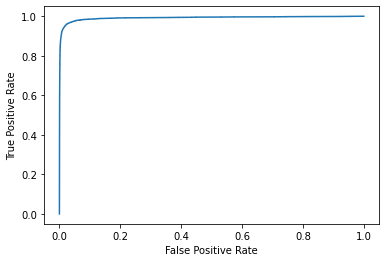

In [90]:
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

Text(0, 0.5, 'True Positive Rate')

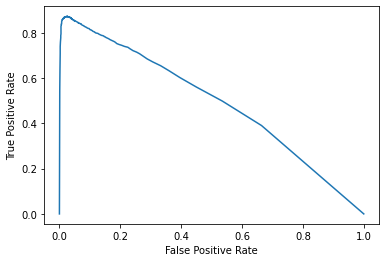

In [80]:
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [54]:
no_damage_indices = np.where((todos_targets.sum(axis=1)==0))[0]

In [61]:
np.sum((np.sum((all_outs_thresholded[no_damage_indices] > 0)*1, axis=1)==0)*1)

0

In [52]:
np.sum((all_outs_thresholded[some_damage_indices] == todos_targets[some_damage_indices])*1, axis=1)

array([1, 2, 2, ..., 2, 2, 1])

In [22]:
all_outs_thresholded.shape

(9550, 8)

In [30]:
todos_targets.shape[1]

8

In [47]:
some_damage_indices = np.where((todos_targets.sum(axis=1)>0))[0]

In [50]:
np.sum((np.sum((all_outs_thresholded[some_damage_indices] == todos_targets[some_damage_indices])*1, axis=1)==todos_targets.shape[1])*1)

0

In [39]:
all_outs_sigmoid = nn.Sigmoid()(todos_logits)

In [47]:
all_outs_thresholded= (all_outs_sigmoid.data.cpu().numpy() > 0.999992).astype(np.uint8)

In [59]:
res = {"Clase":[], "Accuracy":[], "Recall":[], "Precision":[], "F1":[]}
for indx, clase in enumerate(CLASSES):
    pr = precision_score( todos_targets[:,indx], all_outs_thresholded[:,indx], average=avg )
    re = recall_score( todos_targets[:,indx], all_outs_thresholded[:,indx], average=avg )
    f1 = f1_score( todos_targets[:,indx], all_outs_thresholded[:,indx], average=avg )
    acc = accuracy_score( todos_targets[:,indx], all_outs_thresholded[:,indx] )
    print(f"{clase} -> Accuracy: {acc:0.4} / Precision: {pr:0.4} / Recall: {re:0.4} / F1: {f1:0.4}")
    
    res["Clase"].append(clase)
    res["Accuracy"].append(acc)
    res["Recall"].append(re)
    res["Precision"].append(pr)
    res["F1"].append(f1)

Alcantarillado -> Accuracy: 0.9561 / Precision: 0.9561 / Recall: 0.9561 / F1: 0.9561
Marca vial -> Accuracy: 0.8079 / Precision: 0.8079 / Recall: 0.8079 / F1: 0.8079
Hueco -> Accuracy: 0.9359 / Precision: 0.9359 / Recall: 0.9359 / F1: 0.9359
Parcheo -> Accuracy: 0.9075 / Precision: 0.9075 / Recall: 0.9075 / F1: 0.9075
Grietas longitudinales -> Accuracy: 0.7838 / Precision: 0.7838 / Recall: 0.7838 / F1: 0.7838
Grietas en forma de piel de cocodrilo -> Accuracy: 0.9499 / Precision: 0.9499 / Recall: 0.9499 / F1: 0.9499
Grietas transversales -> Accuracy: 0.8289 / Precision: 0.8289 / Recall: 0.8289 / F1: 0.8289
Meteorización y desprendimiento -> Accuracy: 0.953 / Precision: 0.953 / Recall: 0.953 / F1: 0.953


In [60]:
pd.DataFrame(res)

,Clase,Accuracy,Recall,Precision,F1
0,Alcantarillado,0.956126,0.956126,0.956126,0.956126
1,Marca vial,0.807853,0.807853,0.807853,0.807853
2,Hueco,0.935916,0.935916,0.935916,0.935916
3,Parcheo,0.907539,0.907539,0.907539,0.907539
4,Grietas longitudinales,0.783770,0.783770,0.783770,0.783770
5,Grietas en forma de piel de cocodrilo,0.949948,0.949948,0.949948,0.949948
6,Grietas transversales,0.828901,0.828901,0.828901,0.828901
7,Meteorización y desprendimiento,0.952984,0.952984,0.952984,0.952984


In [30]:
all_outs_thresholded

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [12]:
accuracy_score( all_targets[:,indx], all_outs_thresholded[:,indx] )

0.9910994764397906

In [10]:
all_targets[:,indx]

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)